# Preliminary Sizing
### EAE 130A

The following code outlines how we performed our preliminary sizing calculations. It is derived from the preliminary sizing tutorial.

In [246]:
import math
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLines

Intro & Equation explanation

0.013
0.0251334215945771


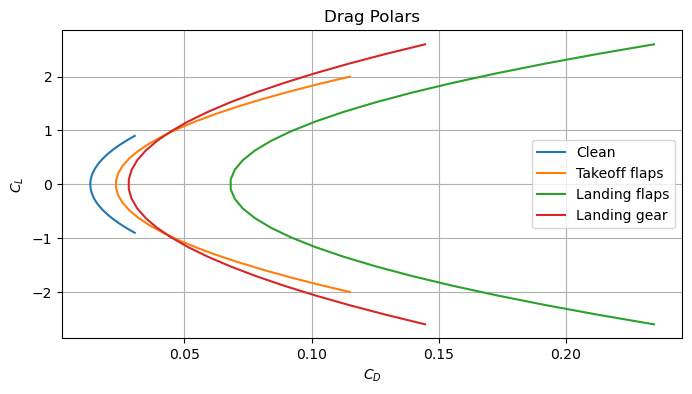

In [247]:
## Drag Polar Estimate
w_to = 57006    #lbs, takeoff weight
c_f = 0.0026    #skin friction coefficient, Raymer 12.3
c_l = 0.75       ##lift coefficient
"""
c = -0.0866     #Table 3.5 Roskam
d = 0.8099      #Table 3.5 Roskam
s_wet = (10**c)*(w_to**d)
print(s_wet)
rho = 0.0023769        #slug/ft3
c_lmax = 1.9
c_lcruise = 0.5
v_stall = 590.733*np.sqrt(c_lcruise/c_lmax)         #stall speed, ft/s
ws = 0.5*rho*(v_stall**2)*c_l #wingloading, Martins Eq 4.2  #lb/sqft
print(ws)   
s_ref = w_to/ws   #sq.ft, from tutorial
print(s_ref)  
""" 


s_ratio = 5     
c_do = c_f*(s_ratio)
print(c_do)
delta_cdo = [0, 0.010, 0.055, 0.015] # [clean, TO flaps, L flaps, landing gear down]
e_v = 0.80
AR = 18.44588       # aspect ratio, from openVSP model
c_d = c_do + ((c_l**2)/((np.pi)*e_v*AR))
print(c_d)
e_v = [0.80, 0.75, 0.70, 1] ## span efficiency factor, array

# Adjust C_Lmax for each flight configuration
cL_clean = np.linspace(-0.9,0.9,30)
cL_takeoff = np.linspace(-2,2,30)
cL_landing = np.linspace(-2.6,2.6,30)
clean = (c_do + delta_cdo[0]) + ((cL_clean**2)/((np.pi)*e_v[0]*AR))
takeoff = (c_do + delta_cdo[1]) + ((cL_takeoff**2)/((np.pi)*e_v[1]*AR))
landing_flaps = (c_do + delta_cdo[2]) + ((cL_landing**2)/((np.pi)*e_v[2]*AR))
landing_gear = (c_do + delta_cdo[3]) + ((cL_landing**2)/((np.pi)*e_v[3]*AR))

plt.figure(figsize=(8,4))
plt.title('Drag Polars')
plt.xlabel("$C_D$")
plt.ylabel("$C_L$")
plt.plot(clean, cL_clean, label='Clean', linestyle='-')
plt.plot(takeoff, cL_takeoff, label='Takeoff flaps', linestyle='-')
plt.plot(landing_flaps, cL_landing, label='Landing flaps', linestyle='-')
plt.plot(landing_gear, cL_landing, label='Landing gear', linestyle='-')
plt.legend(loc='best')
plt.grid()
plt.show()

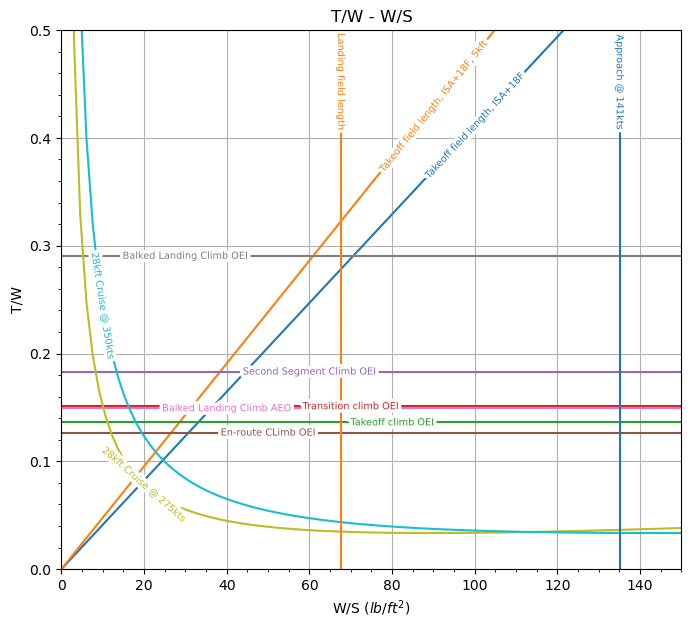

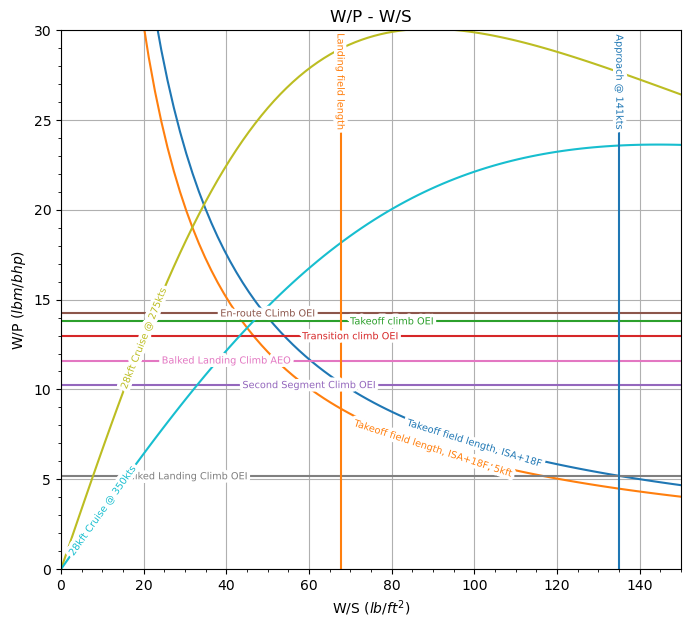

In [248]:
## Constraint Diagram
# useful definitions
N = 100
ws = np.linspace(0.01,150,N)
tw = np.linspace(0,.5,N)
wp = np.linspace(0,30,N)

## Takeoff Field Length
# Assumption: BFL = 4500 from FAR 25 TO Requirements (35 ft obstacle)
CL_max_TO = 2.1 # (Roskam)
BFL = 4500 # ft
TOP_25 = BFL/37.5
rho_SLp18F = 0.0024428 # slug/ft3, density at ISA + 18F
rho_p18F_5kft = 0.002107 # slug/ft3, density at ISA + 18F
rho_SL = 0.0025332 # slug/ft3, density at ISA
tw_tofl = ws/((rho_SLp18F/rho_SL)*CL_max_TO*TOP_25) 
wp_tofl = 1/(0.3467*tw_tofl)

tw_tofl_5kft = ws/((rho_p18F_5kft/rho_SL)*CL_max_TO*TOP_25) 
wp_tofl_5kft = 1/(0.3467*tw_tofl_5kft)

# s_land = bfl * 0.6

# rho_tot = 0.95  #given during tutorial
# c_lto = 2.1
# tw_tofl = ws/((rho_tot)*c_lto*top)





## Climb Segments
eta_p_climb = 0.75
V_a = 141*1.68780986 # ft/s approach speed, requirement
V_so = V_a/1.3 

def tw_climb(n_engines,n_engines_max,k_s,e_v,CL_max,CD_0,G,N):
    return ((1/0.8)*(n_engines_max/(n_engines))*((((k_s**2)/CL_max)*(CD_0))+(CL_max/((k_s**2)*np.pi*e_v*AR))+G))*np.ones(N)

# TO climb
n_engines_max = 2
n_engines = 1
k_s_TO = 1.2
G_TO = 0.012
e_TO = 0.75    
c_lmax_TO = 2.1
CD_0_TO = c_do 
tw_climb_TO = tw_climb(n_engines,n_engines_max,k_s_TO,e_TO,c_lmax_TO,CD_0_TO,G_TO,N)
wp_climb_TO = 550*eta_p_climb/(tw_climb_TO*V_so*k_s_TO)

# Transition climb
n_engines_max = 2
n_engines = 1
k_s_TC = 1.15
G_TC = 0
e_TC = 0.75    
c_lmax_TC = 2.1
CD_0_TC = c_do + delta_cdo[1] + delta_cdo[3]
tw_climb_TC = tw_climb(n_engines,n_engines_max,k_s_TC,e_TC,c_lmax_TC,CD_0_TC,G_TC,N)
wp_climb_TC = 550*eta_p_climb/(tw_climb_TC*V_so*k_s_TC)

# Second Segment Climb
n_engines_max = 2
n_engines = 1
k_s_SSC = 1.2
G_SSC = 0.024
e_SSC = 0.75    
c_lmax_SSC = 2.1
CD_0_SSC = c_do + delta_cdo[1] 
tw_climb_SSC = tw_climb(n_engines,n_engines_max,k_s_SSC,e_SSC,c_lmax_SSC,CD_0_SSC,G_SSC,N)
wp_climb_SSC = 550*eta_p_climb/(tw_climb_SSC*V_so*k_s_SSC)

# En Route Climb
n_engines_max = 2
n_engines = 1
k_s_ERC = 1.25
G_ERC = 0.012
e_ERC = 0.75
c_lmax_ERC = 1.9
CD_0_ERC = c_do 
tw_climb_ERC = tw_climb(n_engines,n_engines_max,k_s_ERC,e_ERC,c_lmax_ERC,CD_0_ERC,G_ERC,N)
wp_climb_ERC = 550*eta_p_climb/(tw_climb_ERC*V_so*k_s_ERC)

# Balked Landing Climb AEO
n_engines_max = 2
n_engines = 2
k_s_BLC_AEO = 1.3
G_BLC = 0.032
e_BLC = 0.75
c_lmax_BLC = 3.3
CD_0_BLC = c_do + delta_cdo[2] + delta_cdo[3]
tw_climb_BLC_AEO = tw_climb(n_engines,n_engines_max,k_s_BLC_AEO,e_BLC,c_lmax_BLC,CD_0_BLC,G_BLC,N)
wp_climb_BLC_AEO = 550*eta_p_climb/(tw_climb_BLC_AEO*V_so*k_s_BLC_AEO)

# Balked Landing Climb OEI
n_engines_max = 2
n_engines = 1
k_s_BLC_OEI = 1.5
G_BLC = 0.021
e_BLC = 0.75
c_lmax_BLC = 3.3*0.85
CD_0_BLC = c_do + delta_cdo[2] + delta_cdo[3]
tw_climb_BLC_OEI = tw_climb(n_engines,n_engines_max,k_s_BLC_OEI,e_BLC,c_lmax_BLC,CD_0_BLC,G_BLC,N)
wp_climb_BLC_OEI = 550*eta_p_climb/(tw_climb_BLC_OEI*V_so*k_s_BLC_OEI)

## Cruise
# Asssumptions: 
# 28kft cruise
# constant speed prop (Gudmundsson)
eta_p_max = 0.85 # prop eff at cruise
rho_28kft = 10.66e-4 # slug/ft3, air density at cruise (28kft)
V_min = 275*1.68780986 # ft/s, 275 kts requirement
V_target = 350*1.68780986 # ft/s, 350 kts target
q_min = 0.5*rho_28kft*V_min**2 # psf, dyn pressure at cruise requirement
q_target = 0.5*rho_28kft*V_target**2 # psf, dyn pressure at cruise target
# print(q_min,q_target)
tw_cruise_min = ((q_min*c_do)/ws) + ws*(1/(q_min*(np.pi)*AR*e_v[0])) # tw at cruise requirement
tw_cruise_target = ((q_target*c_do)/ws) + ws*(1/(q_target*(np.pi)*AR*e_v[0])) # tw at cruise target 

wp_cruise_min = 1/tw_cruise_min/(V_min/(eta_p_max*550)) # wp at cruise requirement 
wp_cruise_target = 1/tw_cruise_target/(V_target/(eta_p_max*550)) # wp at cruise target

## Approach Speed (in terms of stall speed)
CL_max_L = 3.3 # (Roskam)
V_a = 141*1.68780986 # ft/s approach speed, requirement
V_so = V_a/1.3
ws_approach_SLp18 = 1/2*rho_SLp18F*V_so**2*CL_max_L*np.ones(N) # slug/ft3, density at ISA + 18F

## Landing Field Length
s_a = 1000 # FAR 25, Martins
s_FL = 4500 # ft, field length requirement
s_L = s_FL*0.6

ws_landing_SLp18=(((rho_SLp18F/rho_SL)*CL_max_L)*(s_L - s_a))/80*np.ones(N) 


# plotting TW
plt.figure(figsize=(8,7))
plt.title('T/W - W/S')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("T/W")
plt.plot(ws, tw_tofl, label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, tw_tofl_5kft, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, tw_climb_TO, label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, tw_climb_TC, label='Transition climb OEI', linestyle='-')
plt.plot(ws, tw_climb_SSC, label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, tw_climb_ERC, label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, tw_climb_BLC_AEO, label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, tw_climb_BLC_OEI, label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, tw_cruise_min, label='28kft Cruise @ 275kts', linestyle='-')
plt.plot(ws, tw_cruise_target, label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/11):], np.flip(tw)[int(N/11):], label='Approach @ 141kts', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/11):], np.flip(tw)[int(N/11):], label='Landing field length', linestyle='-')

plt.ylim(0, 0.5), plt.xlim(0, 150)
plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,130))
# plt.legend(loc='best')
# plt.show()


# plotting WP
plt.figure(figsize=(8,7))
plt.title('W/P - W/S')
plt.xlabel("W/S $(lb/ft^2)$")
plt.ylabel("W/P $(lbm/bhp)$")
plt.plot(ws, wp_tofl, label='Takeoff field length, ISA+18F', linestyle='-')
plt.plot(ws, wp_tofl_5kft, label='Takeoff field length, ISA+18F, 5kft', linestyle='-')

plt.plot(ws, wp_climb_TO, label='Takeoff climb OEI', linestyle='-')
plt.plot(ws, wp_climb_TC, label='Transition climb OEI', linestyle='-')
plt.plot(ws, wp_climb_SSC, label='Second Segment Climb OEI', linestyle='-')
plt.plot(ws, wp_climb_ERC, label='En-route CLimb OEI', linestyle='-')
plt.plot(ws, wp_climb_BLC_AEO, label='Balked Landing Climb AEO', linestyle='-')
plt.plot(ws, wp_climb_BLC_OEI, label='Balked Landing Climb OEI', linestyle='-')

plt.plot(ws, wp_cruise_min, label='28kft Cruise @ 275kts', linestyle='-')
plt.plot(ws, wp_cruise_target, label='28kft Cruise @ 350kts', linestyle='-')

plt.plot(ws_approach_SLp18[int(N/11):], np.flip(wp)[int(N/11):], label='Approach @ 141kts', linestyle='-')
plt.plot(ws_landing_SLp18[int(N/11):], np.flip(wp)[int(N/11):], label='Landing field length', linestyle='-')


# plt.plot(ws, tw_climb, label='Takeoff climb', linestyle='-')

plt.ylim(0, 30), plt.xlim(0, 150)
plt.grid()
plt.minorticks_on()
labelLines(plt.gca().get_lines(), zorder=2.5,fontsize = 7,xvals=(0,130))
plt.show()

In [249]:
print('Sized Wing Area: {}ft2, Sized Power: {}bhp'.format(w_to/65, w_to/5))

Sized Wing Area: 877.0153846153846ft2, Sized Power: 11401.2bhp
